**Downloading dataset directly from Kaggle**

In [2]:
# %pip install opendatasets --quiet
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

%pip install kaggle --quiet
!kaggle datasets download -d mssmartypants/rice-type-classification

Note: you may need to restart the kernel to use updated packages.
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification
License(s): copyright-authors




  0%|          | 0.00/888k [00:00<?, ?B/s]
100%|██████████| 888k/888k [00:00<00:00, 453MB/s]


In [3]:
import zipfile
from pathlib import Path

zip_path = Path("rice-type-classification.zip")
out_dir = Path("rice-type-classification")

out_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path) as z:
    z.extractall(out_dir)


**Importing Libraries**

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pytorch cannot automatically detect the GPU, unlike Tensorflow
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [11]:
import os
print(os.getcwd())


e:\Codes\ML\Project_1


**Reading dataset**

In [12]:
# data_df = pd.read_csv("Project_1/rice-type-classification/riceClassification.csv")
# data_df.head()

import os

path = os.path.join("rice-type-classification", "riceClassification.csv")
data_df = pd.read_csv(path)


**Data Preprocessing**

In [13]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)
data_df.head()

(18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [14]:
print(data_df['Class'].unique())
print(data_df['Class'].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


**Normalize Data**

In [15]:
original_df = data_df.copy()
for col in data_df.columns:
  data_df[col] = data_df[col]/data_df[col].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


**Splitting data into features & label**

In [16]:
X = np.array(data_df.iloc[:, :-1])    #iloc[rows, columns]
Y = np.array(data_df.iloc[:, -1])

**Splitting data for training and testing**

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

**Splitting testing data into validation and testing**

In [18]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [19]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


**Creating a Pytorch class by inheriting & overriding Dataset class which is a builtin class in Pytorch. This is done because Pytorch only understands tensor data.**

In [20]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


**Train, test & validate the splitted data using Pytorch**

In [21]:
train_data = dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)
test_data = dataset(x_test, y_test)


**Using Dataloader to create batches of the data to be trained.**

In [22]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [23]:
for x, y in train_dataloader:
  print(x)
  print("----------------------")
  print(y)
  break

tensor([[0.9240, 0.8755, 0.9192, 0.9113, 0.8799, 0.9612, 0.6977, 0.7593, 0.8789,
         0.5403],
        [0.6509, 0.7816, 0.7257, 0.9395, 0.6305, 0.8068, 0.6347, 0.6701, 0.7949,
         0.6111],
        [0.8838, 0.8730, 0.8819, 0.9210, 0.8445, 0.9401, 0.6548, 0.7606, 0.8378,
         0.5616],
        [0.7841, 0.8370, 0.8179, 0.9287, 0.7445, 0.8855, 0.6624, 0.7144, 0.8425,
         0.5805],
        [0.5619, 0.8146, 0.6008, 0.9756, 0.5392, 0.7496, 0.8439, 0.6447, 0.7413,
         0.7693],
        [0.9192, 0.9039, 0.8815, 0.9291, 0.8658, 0.9587, 0.6831, 0.7634, 0.8651,
         0.5817],
        [0.6541, 0.8777, 0.6516, 0.9748, 0.6245, 0.8087, 0.6124, 0.7076, 0.7163,
         0.7642],
        [0.8364, 0.8380, 0.8736, 0.9131, 0.7996, 0.9146, 0.6971, 0.7295, 0.8621,
         0.5442],
        [0.6452, 0.8884, 0.6368, 0.9789, 0.6146, 0.8033, 0.6434, 0.7055, 0.7110,
         0.7915],
        [0.8497, 0.8873, 0.8317, 0.9376, 0.8026, 0.9218, 0.6367, 0.7463, 0.8366,
         0.6053],
        [0

**Build a model by inheriting Pytorch's builtin model & then overriding.**

In [24]:
no_of_neurons = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.input_layer = nn.Linear(X.shape[1], no_of_neurons)
    self.linear = nn.Linear(no_of_neurons, 1) # nn.Linear(input_size, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x): # Determines how the data flows inside the model
    x = self.input_layer(x) # First data goes to input layer
    x = self.linear(x)  # Then to the linear layer
    x = self.sigmoid(x) # Lastly it goes to the sigmoid function
    return x  # Output of the sigmoid function is returned

model = MyModel().to(device)

**Summary of the model**

In [25]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


**Initializing Loss function & Optimizer**

In [26]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

**Training the model**

In [27]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs, labels = data

    # Forward Propagation
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc

    # Backward Propagation
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data

      predictions = model(inputs).squeeze(1)
      batch_loss = criterion(predictions, labels)
      total_loss_val += batch_loss.item()
      acc = ((predictions).round() == labels).sum().item()
      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

  print(f'''Epoch no. {epoch + 1}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy: {round(total_acc_train/train_data.__len__() * 100, 4)}
            Validation Loss: {round(total_loss_val/1000, 4)}, Validation Accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}''')

  print("-" * 50)




Epoch no. 1, Train Loss: 0.2346, Train Accuracy: 83.8715
            Validation Loss: 0.0381, Validation Accuracy: 98.3871
--------------------------------------------------
Epoch no. 2, Train Loss: 0.1212, Train Accuracy: 98.0988
            Validation Loss: 0.0164, Validation Accuracy: 98.7903
--------------------------------------------------
Epoch no. 3, Train Loss: 0.0576, Train Accuracy: 98.3974
            Validation Loss: 0.009, Validation Accuracy: 98.7537
--------------------------------------------------
Epoch no. 4, Train Loss: 0.0366, Train Accuracy: 98.5388
            Validation Loss: 0.0064, Validation Accuracy: 98.827
--------------------------------------------------
Epoch no. 5, Train Loss: 0.0281, Train Accuracy: 98.5623
            Validation Loss: 0.0051, Validation Accuracy: 98.7903
--------------------------------------------------
Epoch no. 6, Train Loss: 0.0239, Train Accuracy: 98.5859
            Validation Loss: 0.0045, Validation Accuracy: 98.7903
---------

**Testing the model**

In [28]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, labels)
    total_loss_test += batch_loss_test.item()

    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy: {round(total_acc_test/test_data.__len__() * 100, 4)}")


Accuracy: 98.5337


**Creating Plots**

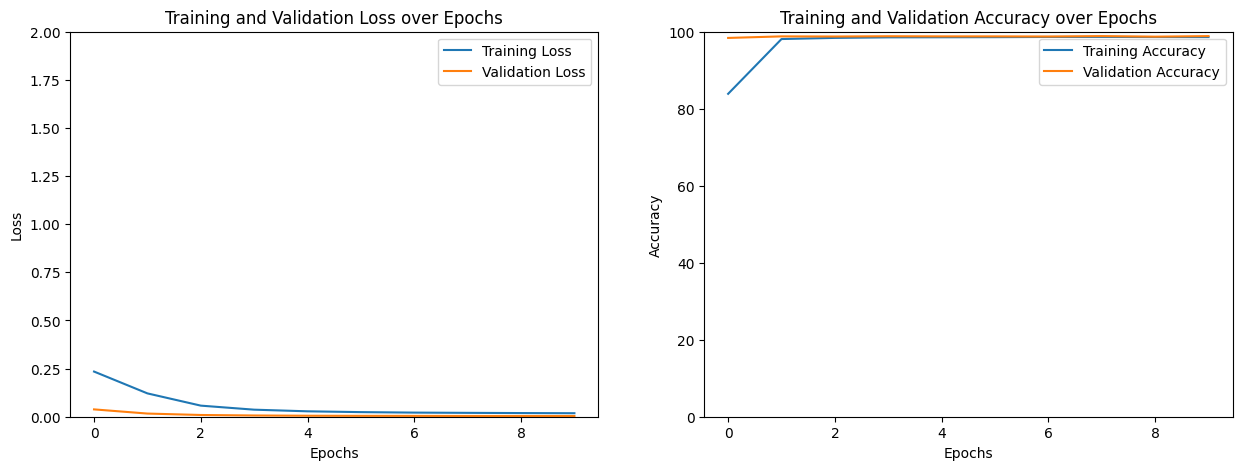

In [29]:
from IPython.core.pylabtools import figsize
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotting loss over epochs
axis[0].plot(total_loss_train_plot, label="Training Loss")
axis[0].plot(total_loss_validation_plot, label="Validation Loss")
axis[0].set_title("Training and Validation Loss over Epochs")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_ylim([0, 2])
axis[0].legend()

# Plotting accuracy over epochs
axis[1].plot(total_acc_train_plot, label="Training Accuracy")
axis[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axis[1].set_title("Training and Validation Accuracy over Epochs")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].set_ylim([0, 100])
axis[1].legend()

plt.show()

**Inferencing**

In [30]:
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [31]:
area = 2358/original_df['Area'].abs().max()
majorAxisLength = 76.293164/original_df['MajorAxisLength'].abs().max()
minorAxisLength = 56.374021/original_df['MinorAxisLength'].abs().max()
eccentricity = 0.725553/original_df['Eccentricity'].abs().max()
convexArea = 3157/original_df['ConvexArea'].abs().max()
equivDiameter = 60.471018/original_df['EquivDiameter'].abs().max()
extent = 0.769375/original_df['Extent'].abs().max()
perimeter = 273.085/original_df['Perimeter'].abs().max()
roundness = 0.870203/original_df['Roundness'].abs().max()
aspectRation = 1.413197/original_df['AspectRation'].abs().max()

inp = torch.tensor([area, majorAxisLength, minorAxisLength, eccentricity, convexArea, equivDiameter, extent, perimeter, roundness, aspectRation], dtype = torch.float32).to(device)

model(inp).round()



tensor([1.], grad_fn=<RoundBackward0>)